# Citations

This notebook uses the Beijing PM2.5 Data Data Set downloaded from the UCI Machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

**Dataset citation:**
Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.

**UCI Machine Learning Repository citation:**
re3data.org: UCI Machine Learning Repository; editing status 2017-10-30; re3data.org - Registry of Research Data Repositories. http://doi.org/10.17616/R3T91Q last accessed: 2020-12-20

# General Setup

In [ ]:
!pip install scipy sklearn pandas 'torch-lr-finder==0.2.0'
!rm -vrf '/tobit_loss'
!git clone https://github.com/vlad-danaila/tobit_loss.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'tobit_loss' already exists and is not an empty directory.


Add the Tobit loss to Python path.

In [ ]:
import sys
sys.path.insert(0, './tobit_loss')

Imports

In [ ]:
import torch as t
from deep_tobit.util import to_torch, to_numpy, normalize, unnormalize, distinguish_censored_versus_observed_data
from deep_tobit.loss import Heteroscedastic_Reparametrized_Scaled_Tobit_Loss
from deep_tobit.normal_cumulative_distribution_function import cdf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import random
import sklearn as sk
import sklearn.metrics
import math
from sklearn.model_selection import ParameterGrid
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
import os
import numpy.random
import collections
import pandas as pd
import requests
import sklearn.decomposition
import traceback
from scipy.stats import norm
from typing import Tuple, Union

Constants

In [ ]:
URL_BEIJING_PM_2_5_DATA_SET = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
DATASET_FILE = 'Beijing PM2.5 dataset.csv'

GRID_RESULTS_FILE = 'grid_results.tar'

CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED = 'reparametrized deep tobit model'
CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED = 'reparametrized truncated deep tobit model'
CHECKPOINT_LINEAR_TOBIT_REPARAMETRIZED = 'reparametrized linear tobit model'
CHECKPOINT_LINEAR_TRUNCATED_TOBIT_REPARAMETRIZED = 'reparametrized truncated linear tobit model'

CENSOR_LOW_BOUND = 75
CENSOR_HIGH_BOUND = 300
LAYER_SIZE = 10
CHECKPOINT_FREQUENCY = 10

CUDA = t.cuda.is_available()

GRADIENT_CLIP = 100

Reproducible experiments

In [ ]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

# Model

In [ ]:
class DenseNetwork(t.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_in = t.nn.Linear(46, LAYER_SIZE)
    self.norm_1 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False, momentum = None)
    self.drop_1 = t.nn.Dropout(p = .2)
    self.layer_hidden_1 = t.nn.Linear(LAYER_SIZE, LAYER_SIZE)
    self.norm_2 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False, momentum = None)
    self.drop_2 = t.nn.Dropout(p = .2)
    self.layer_out = t.nn.Linear(LAYER_SIZE, 1)

  def forward(self, x):
    x = t.nn.functional.relu(self.norm_1(self.layer_in(x)))
    x = self.drop_1(x)
    x = t.nn.functional.relu(self.norm_2(self.layer_hidden_1(x)))
    x = self.drop_2(x)
    x = self.layer_out(x)
    return x

In [ ]:
class GammaNetwork(t.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_in = t.nn.Linear(46, LAYER_SIZE)
    self.norm_1 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False)
    self.layer_out = t.nn.Linear(LAYER_SIZE, 1)

  def forward(self, x):
    x = self.layer_in(x)
    x = self.norm_1(x)
    x = t.nn.functional.relu(x)    
    x = self.layer_out(x)  
    return x

In [ ]:
def get_model(cuda = CUDA, net = None):  
  if net == None:
    net = DenseNetwork()
  if cuda:
    net = net.cuda()
  net = t.nn.DataParallel(net)
  return net

In [ ]:
def get_device(cuda = CUDA):
  return 'cuda:0' if cuda else 'cpu'

In [ ]:
def get_gamma(cuda = CUDA):
  gamma = GammaNetwork()
  if cuda:
    gamma = gamma.cuda()
  gamma = t.nn.DataParallel(gamma)
  return gamma

# Datasets

In [ ]:
r = requests.get(URL_BEIJING_PM_2_5_DATA_SET, allow_redirects=True)
open(DATASET_FILE, 'wb').write(r.content)

2010494

In [ ]:
def load_dataframe(filter_null = True):
  df = pd.read_csv(DATASET_FILE)
  # exclude records without a measured pm2.5
  if filter_null:
    df = df[df['pm2.5'].notnull()]
  return df

In [ ]:
df = load_dataframe()

In [ ]:
def train_df(df: pd.DataFrame):
  return df[ df.year.isin([2010, 2011, 2012]) ]

def val_df(df: pd.DataFrame):
  return df[ df.year.isin([2013]) ]

def test_df(df: pd.DataFrame):
  return df[ df.year.isin([2014]) ]

In [ ]:
def y_train_mean_std(max_iterations = 10_000, early_stop_patience = 5, lr = 1e-6, epsilon = 1e-6):
  df = train_df(load_dataframe())
  ys = df['pm2.5'].values

  real_mean, real_std = ys.mean(), ys.std()

  y_single_valued, y_left_censored, y_right_censored = [], [], []
  
  for y in ys:
    if y > CENSOR_LOW_BOUND and y < CENSOR_HIGH_BOUND:
      y_single_valued.append(y)
    elif y <= CENSOR_LOW_BOUND:
      y_left_censored.append(CENSOR_LOW_BOUND)
    elif y >= CENSOR_HIGH_BOUND:
      y_right_censored.append(CENSOR_HIGH_BOUND)
    else:
      raise Exception('y outside of valid values, y = {}'.format(y[0]))

  all = np.array(y_single_valued + y_left_censored + y_right_censored)
  data_mean, data_std = all.mean(), all.std()

  return data_mean.item(), data_std.item()

y_mean, y_std = y_train_mean_std()
print(f'mean = {y_mean}; std = {y_std}')

mean = 115.89409452043574; std = 63.0676161648441


In [ ]:
bound_min = normalize(CENSOR_LOW_BOUND, y_mean, y_std)
bound_max = normalize(CENSOR_HIGH_BOUND, y_mean, y_std)
zero_normalized = normalize(0, y_mean, y_std)

In [ ]:
numeric_features_column_names = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

In [ ]:
def x_numeric_fatures_train_mean_std():
  df = train_df(load_dataframe())
  numeric_fetures = df[numeric_features_column_names].values
  mean, std = numeric_fetures.mean(axis = 0), numeric_fetures.std(axis = 0)
  return mean, std

x_numeric_fetures_mean, x_numeric_fetures_std = x_numeric_fatures_train_mean_std()

In [ ]:
def extract_features(df: pd.DataFrame, lower_bound = -math.inf, upper_bound = math.inf):
  assert lower_bound <= upper_bound
  # handle categorical features (one hot encoding)
  one_hot = sk.preprocessing.OneHotEncoder(sparse = False)
  month_one_hot = one_hot.fit_transform(np.expand_dims(df['month'].values, 1))
  # day_one_hot = one_hot.fit_transform(np.expand_dims(df['day'].values, 1))
  hour_one_hot = one_hot.fit_transform(np.expand_dims(df['hour'].values, 1))
  combined_wind_direction_one_hot = one_hot.fit_transform(np.expand_dims(df['cbwd'].values, 1))
  
  # extract the numeric variables
  numeric_fetures = df[numeric_features_column_names].values
  numeric_fetures = normalize(numeric_fetures, x_numeric_fetures_mean, x_numeric_fetures_std)

  # unite all features
  x = np.hstack((month_one_hot, hour_one_hot, combined_wind_direction_one_hot, numeric_fetures))

  # extract the results
  y = df['pm2.5'].values
  y = np.clip(y, lower_bound, upper_bound)
  y = normalize(y, y_mean, y_std)
  y = np.expand_dims(y, 1)

  return x, y

In [ ]:
class PM_2_5_Dataset(t.utils.data.Dataset):
  
  def __init__(self, x: np.array, y: np.array, cuda = CUDA):
    super().__init__()
    self.x = t.tensor(x, requires_grad = True, dtype=t.float32)
    self.y = t.tensor(y, requires_grad = True, dtype=t.float32)
    if cuda:
      self.x = self.x.cuda()
      self.y = self.y.cuda()
    
  def __getitem__(self, i):
    return self.x[i], self.y[i]

  def __len__(self):
    return len(self.y)

In [ ]:
def parse_datasets():
  df = load_dataframe()
  
  # split into training / validation / test
  df_train = train_df(df)
  df_val = val_df(df)
  df_test = test_df(df)

  dataset_train = PM_2_5_Dataset(*extract_features(df_train, lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND))
  dataset_val = PM_2_5_Dataset(*extract_features(df_val, lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND))
  dataset_test = PM_2_5_Dataset(*extract_features(df_test))

  return dataset_train, dataset_val, dataset_test

dataset_train, dataset_val, dataset_test = parse_datasets()

In [ ]:
def pca(x, n_components = 1):
  pca_encoder = sk.decomposition.PCA(n_components = n_components)
  return pca_encoder.fit_transform(x)

# Plotting

In [ ]:
def plot_full_dataset(df: pd.DataFrame, size = 0.01, label = None, censored = False):
  if censored:
    x, y = extract_features(df, lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND)
  else:
    x, y = extract_features(df)
  x = pca(x)
  if not censored:
    min_max = [min(x), max(x)]
    plt.plot(min_max, [bound_min] * 2, color = 'red')
    plt.plot(min_max, [bound_max] * 2, color = 'red')
    plt.plot(min_max, [zero_normalized] * 2, color = 'red')
  plt.scatter(x, y, s = size, label = label)
  plt.xlabel('unidimensional PCA')
  plt.ylabel('PM2.5 (standardized)')
  # plt.savefig(label + '.pdf', dpi = 300, format = 'pdf')

In [ ]:
LOSS = 0
ABS_ERR = 1
R_SQUARED = 2

In [ ]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'Train')
    plt.plot(range(len(test)), test, label = 'Test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    # plt.savefig(title + '.png', dpi = 300, format = 'png')
    plt.show()

In [ ]:
def plot_epochs(train_metrics_list, test_metrics_list):
  test_r2 = list(map(lambda m: m[R_SQUARED], test_metrics_list))
  test_err = list(map(lambda m: m[ABS_ERR], test_metrics_list))
  test_loss = list(map(lambda m: m[LOSS], test_metrics_list))
  train_r2 = list(map(lambda m: m[R_SQUARED], train_metrics_list))
  train_err = list(map(lambda m: m[ABS_ERR], train_metrics_list))
  train_loss = list(map(lambda m: m[LOSS], train_metrics_list))
  plot_train_test(train_loss, test_loss, 'Loss', 'Loss')
  plot_train_test(train_err, test_err, 'Absolute error', 'Absolute error')
  plot_train_test(train_r2, test_r2, 'R squared', 'R squared')

In [ ]:
def plot_net(model, gamma_model, df: pd.DataFrame, label = 'model prediction', with_std = False):
  model.eval()
  gamma_model.eval()
  x, y_real = extract_features(df)
  x_pca = pca(x)
  dataset = PM_2_5_Dataset(x, y_real)
  x_list, y_list = [], []
  for i in range(len(dataset)):
    x, _ = dataset[i]
    y_pred = model.forward(x.reshape(1, -1))
    if gamma_model:
      y_pred = y_pred / t.abs(gamma_model(x.reshape(1, -1)))
    x_list.append(to_numpy(x))
    y_list.append(y_pred[0].item())

  x_list = np.array(x_list).squeeze()
  x_pca = np.squeeze(x_pca)
  np_y = np.array(y_list)
  indices_sorted = np.argsort(x_pca)
  
  x_pca_sorted = x_pca[indices_sorted]
  np_y_sorted = np_y[indices_sorted]
  
  if with_std and gamma_model:
    std = to_numpy(1 / t.abs(gamma_model(t.tensor(x_list, dtype=t.float32))))
    std = std.squeeze()
    plt.fill_between(x_pca_sorted, np_y_sorted + std, np_y_sorted - std, facecolor='gray', alpha=.6, label = 'Tobit std')

  plt.scatter(x_pca_sorted, np_y_sorted, s = .1, label = label)

In [ ]:
def plot_std(model, gamma_model, df: pd.DataFrame):
  gamma_model.eval()
  x, y_real = extract_features(df)
  x_pca = pca(x)
  dataset = PM_2_5_Dataset(x, y_real)
  x_list, y_list = [], []
  for i in range(len(dataset)):
    x, _ = dataset[i]
    y_pred = model.forward(x.reshape(1, -1))
    if gamma_model:
      y_pred = y_pred / t.abs(gamma_model(x.reshape(1, -1)))
    x_list.append(to_numpy(x))
    y_list.append(y_pred[0].item())

  x_list = np.array(x_list).squeeze()
  x_pca = np.squeeze(x_pca)
  np_y = np.array(y_list)
  indices_sorted = np.argsort(x_pca)
  
  x_pca_sorted = x_pca[indices_sorted]
  np_y_sorted = np_y[indices_sorted]
  
  std = to_numpy(1 / t.abs(gamma_model(t.tensor(x_list, dtype=t.float32))))
  std = std.squeeze()
  plt.fill_between(x_pca_sorted, np_y_sorted + std, np_y_sorted - std, facecolor='gray', alpha=.6, label = 'Tobit std')
  min_max = [x_pca_sorted[0], x_pca_sorted[-1]]
  plt.plot(min_max, [bound_min] * 2, color = 'red')
  plt.plot(min_max, [bound_max] * 2, color = 'red')
  plt.plot(min_max, [zero_normalized] * 2, color = 'red')

In [ ]:
def plot_fixed_and_dynamic_std(model, gamma_model, fixed_gamma, df: pd.DataFrame):
  gamma_model.eval()
  x, y_real = extract_features(df)
  x_pca = pca(x)
  dataset = PM_2_5_Dataset(x, y_real)
  x_list, y_list = [], []
  for i in range(len(dataset)):
    x, _ = dataset[i]
    y_pred = model.forward(x.reshape(1, -1))
    if gamma_model:
      y_pred = y_pred / t.abs(gamma_model(x.reshape(1, -1)))
    x_list.append(to_numpy(x))
    y_list.append(y_pred[0].item())

  x_list = np.array(x_list).squeeze()
  x_pca = np.squeeze(x_pca)
  np_y = np.array(y_list)
  indices_sorted = np.argsort(x_pca)
  
  x_pca_sorted = x_pca[indices_sorted]
  np_y_sorted = np_y[indices_sorted]
  
  std = to_numpy(1 / t.abs(gamma_model(t.tensor(x_list, dtype=t.float32))))
  std = std.squeeze()

  plt.plot(x_pca_sorted, std, label = 'dynamic std', linewidth = .2)
  plt.plot(x_pca_sorted, [fixed_gamma] * len(x_pca_sorted), label = 'fixed std', linewidth = 1)

# Training

In [ ]:
# n is the nb of samples, k is the nb of regressors (features)
n = len(dataset_train)
k = len(dataset_train[0][0])
print(f'While calculating the adjusted R2, n = {n} and k = {k}')

def adjusted_R2(y, y_pred):
  r2 = sk.metrics.r2_score(y, y_pred)
  return 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) )

While calculating the adjusted R2, n = 24418 and k = 46


In [ ]:
def eval_network(model, gamma_model, loader, loss_fn, batch_size, is_eval_bounded = True):
  model.eval()
  gamma_model.eval()
  with t.no_grad():
    metrics = np.zeros(3)
    total_weight = 0
    for x, y, single_valued_indexes, left_censored_indexes, right_censored_indexes in loader:
      y_single_valued = y[single_valued_indexes]
      y_left_censored = y[left_censored_indexes]
      y_right_censored = y[right_censored_indexes]
      y_tuple = y_single_valued, y_left_censored, y_right_censored
      y_pred = model.forward(x)
      y_pred_single_valued = y_pred[single_valued_indexes]
      y_pred_left_censored = y_pred[left_censored_indexes]
      y_pred_right_censored = y_pred[right_censored_indexes]
      y_pred_tuple = y_pred_single_valued, y_pred_left_censored, y_pred_right_censored
      gamma = gamma_model(x)
      gamma_single_valued = gamma[single_valued_indexes]
      gamma_left_censored = gamma[left_censored_indexes]
      gamma_right_censored = gamma[right_censored_indexes]
      gamma_tuple = gamma_single_valued, gamma_left_censored, gamma_right_censored
      loss = loss_fn(y_pred_tuple, y_tuple, gamma_tuple)
      y_pred = y_pred / t.abs(gamma)
      if is_eval_bounded:
        y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      weight = len(y) / batch_size
      metrics[LOSS] += (loss.item() * weight)
      metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
      metrics[R_SQUARED] += (adjusted_R2(y, y_pred) * weight)
      total_weight += weight
    metrics /= total_weight
    return metrics

In [ ]:
def train_network(model, gamma_model, loss_fn, optimizer, scheduler, loader_train, loader_val, checkpoint_name, 
                  batch_size_train, batch_size_val, epochs, grad_clip = GRADIENT_CLIP, log = True):
  metrics_train_per_epochs, metrics_test_per_epochs = [], []
  best = [math.inf, math.inf, -math.inf]
  try:
    counter = 0
    total_weight = 0
    train_metrics = np.zeros(3)  
    for epoch in range(epochs):    
      try:
        model.train()
        gamma_model.train()        
        for x, y, single_valued_indexes, left_censored_indexes, right_censored_indexes in loader_train:
          counter += 1
          y_single_valued = y[single_valued_indexes]
          y_left_censored = y[left_censored_indexes]
          y_right_censored = y[right_censored_indexes]
          y_tuple = y_single_valued, y_left_censored, y_right_censored
          y_pred = model.forward(x)
          y_pred_single_valued = y_pred[single_valued_indexes]
          y_pred_left_censored = y_pred[left_censored_indexes]
          y_pred_right_censored = y_pred[right_censored_indexes]
          y_pred_tuple = y_pred_single_valued, y_pred_left_censored, y_pred_right_censored
          gamma = gamma_model(x)
          gamma_single_valued = gamma[single_valued_indexes]
          gamma_left_censored = gamma[left_censored_indexes]
          gamma_right_censored = gamma[right_censored_indexes]
          gamma_tuple = gamma_single_valued, gamma_left_censored, gamma_right_censored
          loss = loss_fn(y_pred_tuple, y_tuple, gamma_tuple)
          loss.backward()
          t.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
          t.nn.utils.clip_grad_norm_(gamma_model.parameters(), grad_clip)
          optimizer.step()
          optimizer.zero_grad()
          y_pred = y_pred / t.abs(gamma)
          y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          weight = len(y) / batch_size_train
          train_metrics[LOSS] += (loss.item() * weight)
          train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
          train_metrics[R_SQUARED] += (adjusted_R2(y, y_pred) * weight)
          total_weight += weight
          scheduler.step()
          if counter % CHECKPOINT_FREQUENCY == 0:
            train_metrics /= total_weight  
            metrics_train_per_epochs.append(train_metrics)
            train_metrics = np.zeros(3)
            total_weight = 0
            test_metrics = eval_network(model, gamma_model, loader_val, loss_fn, batch_size_val)
            metrics_test_per_epochs.append(test_metrics)
            # if test_metrics[R_SQUARED] > best[R_SQUARED]:
            if test_metrics[ABS_ERR] < best[ABS_ERR]:  
              best = test_metrics
              checkpoint_dict = {'model': model.state_dict()}
              checkpoint_dict['gamma'] = gamma_model.state_dict()
              t.save(checkpoint_dict, '{}.tar'.format(checkpoint_name))
            if log:
              print('Iteration {} abs err {} R2 {}'.format(counter, test_metrics[ABS_ERR], test_metrics[R_SQUARED]))
      except:
        traceback.print_exc() 
        break
    print('Best absolute error:', best[ABS_ERR], 'R2:', best[R_SQUARED])
    return metrics_train_per_epochs, metrics_test_per_epochs, best
  except KeyboardInterrupt as e:
    print('Training interrupted at epoch', epoch)

# Grid Search Setup

In [ ]:
from datetime import datetime
def get_time_string():
  return datetime.utcnow().strftime("%m_%d_%H")

In [ ]:
def grid_search(grid_config, train_callback, checkpoint_name, nb_iterations = 1, conf_validation = None):
  configs = ParameterGrid(grid_config)
  configs_len = len(configs)
  counter = 0
  checkpoint_file = checkpoint_name + '.tar'
  grid_checkpoint_file = 'grid ' + checkpoint_file
  try:
    resume_grid_search = t.load(GRID_RESULTS_FILE)
  except FileNotFoundError:
    resume_grid_search = None

  results = {}
  best = [math.inf, math.inf, -math.inf]
  if resume_grid_search is not None and 'best' in resume_grid_search:
    best_conf = resume_grid_search['best']
    print('Best previous configuration', best_conf)
    best = resume_grid_search[str(best_conf)]
    print(f'Best previous metrics abs err = {best[ABS_ERR]}, R2 = {best[R_SQUARED]}')
    results = resume_grid_search

  for conf in ParameterGrid(grid_config):
    counter += 1
    
    if resume_grid_search is not None and str(conf) in resume_grid_search:
        print('Allready evaluated configuration', conf)
        continue

    if not conf_validation(conf):
      print('Skipping over configuration', conf)
      results[str(conf)] = 'invalid'
      continue
    
    print('-' * 5, 'grid search {}/{}'.format(counter, configs_len), '-' * 5)
    print('Config:', conf)
    
    best_from_iterations = [math.inf, math.inf, -math.inf]
    
    for i in range(nb_iterations):
      if nb_iterations != 1:
        print('Iteration', i + 1)
      metrics = train_callback(conf)
      
      # if metrics[R_SQUARED] > best[R_SQUARED]:
      if metrics[ABS_ERR] < best[ABS_ERR] and not (math.isnan(metrics[LOSS] or math.isnan(metrics[ABS_ERR]) or math.isnan(metrics[R_SQUARED]))):  
        best_from_iterations = metrics
        best = metrics
        results['best'] = conf
        if os.path.exists(grid_checkpoint_file):
          os.remove(grid_checkpoint_file)
        os.rename(checkpoint_file, grid_checkpoint_file)  
    else:
      results[str(conf)] = best_from_iterations
      t.save(results, GRID_RESULTS_FILE)
    
  return best

In [ ]:
def train_and_evaluate_CEnsored(checkpoint, model_fn = get_model, plot = False, log = True, cuda = CUDA, truncated_low = None, truncated_high = None):
  def grid_callback(conf):
    loader_train = t.utils.data.DataLoader(dataset_train, batch_size = conf['batch'], shuffle = True, num_workers = 0, collate_fn = censored_collate_fn)
    loader_val = t.utils.data.DataLoader(dataset_val, batch_size = len(dataset_val), shuffle = False, num_workers = 0, collate_fn = censored_collate_fn)

    model = model_fn()
    gamma_model = get_gamma()
    loss_fn = Heteroscedastic_Reparametrized_Scaled_Tobit_Loss(get_device(cuda), truncated_low = truncated_low, truncated_high = truncated_high)
    params = [
      {'params': model.parameters()},
      {'params': gamma_model.parameters()}
    ]
    optimizer = t.optim.SGD(params, lr = conf['max_lr'] / conf['div_factor'], momentum = conf['max_momentum'], weight_decay = conf['weight_decay'])
    scheduler = t.optim.lr_scheduler.OneCycleLR(
      optimizer, 
      max_lr = conf['max_lr'], 
      steps_per_epoch = len(loader_train), 
      epochs = conf['epochs'],
      pct_start = conf['pct_start'],
      anneal_strategy = conf['anneal_strategy'],
      base_momentum = conf['base_momentum'],
      max_momentum = conf['max_momentum'],
      div_factor = conf['div_factor'],
      final_div_factor = conf['final_div_factor']
    )
    train_metrics, val_metrics, best = train_network(
        model, gamma_model, loss_fn, optimizer, scheduler, loader_train, loader_val, checkpoint, conf['batch'], len(dataset_val), conf['epochs'], grad_clip = conf['grad_clip'], log = log)
    if plot:
      plot_epochs(train_metrics, val_metrics)
    return best
  return grid_callback

In [ ]:
def config_validation(conf):
  return conf['div_factor'] <= conf['final_div_factor'] and conf['max_momentum'] >= conf['base_momentum']

# Plot Selected(With Grid) Model

In [ ]:
def plot_and_evaluate_CEnsored(checkpoint_name, isGrid = True, model_fn = get_model, truncated_low = None, truncated_high = None):
  checkpoint = t.load(('grid ' if isGrid else '') + checkpoint_name + '.tar')
  model = model_fn()
  model.load_state_dict(checkpoint['model'])
  model.eval()

  gamma_model = get_gamma()
  gamma_model.load_state_dict(checkpoint['gamma'])
  gamma_model.eval()

  loss_fn = Heteroscedastic_Reparametrized_Scaled_Tobit_Loss(get_device(), truncated_low = truncated_low, truncated_high = truncated_high)
  
  plot_full_dataset(test_df(df), size = .3, label = 'ground truth')
  plot_net(model, gamma_model, test_df(df))
  plt.xlabel('unidimensional PCA')
  plt.ylabel('PM2.5 (standardized)')
  plt.ylim([-6, 9])
  lgnd = plt.legend(loc='upper left')
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  plt.savefig('{}.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}.png'.format(checkpoint_name), dpi = 200, format = 'png')
  plt.show()

  plot_full_dataset(test_df(df), size = .3, label = 'ground truth')
  plot_net(model, gamma_model, test_df(df), with_std = True)
  plt.xlabel('unidimensional PCA')
  plt.ylabel('PM2.5 (standardized)')
  plt.ylim([-6, 9])
  lgnd = plt.legend(loc='upper left')
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  lgnd.legendHandles[2]._sizes = [10]
  plt.savefig('{}-with-std.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}-with-std.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}-with-std.png'.format(checkpoint_name), dpi = 200, format = 'png')
  plt.show()

  plot_std(model, gamma_model, test_df(df))
  plt.ylim([-4, 4])
  plt.xlabel('unidimensional PCA')
  plt.ylabel('PM2.5 (standardized)')
  plt.ylim([-6, 9])
  lgnd = plt.legend(loc='upper left')
  lgnd.legendHandles[0]._sizes = [10]
  plt.savefig('{}-std-only.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}-std-only.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.show()

  plot_fixed_and_dynamic_std(model, gamma_model, 0.9171,  test_df(df))
  plt.xlabel('unidimensional PCA')
  plt.ylabel('standard deviation')
  lgnd = plt.legend(loc='upper left')
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  plt.savefig('{}-two-std.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}-two-std.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}-std-only.png'.format(checkpoint_name), dpi = 200, format = 'png')
  plt.show()

  loader_val = t.utils.data.DataLoader(dataset_val, batch_size = len(dataset_val), shuffle = False, num_workers = 0, collate_fn = censored_collate_fn)
  val_metrics = eval_network(model, gamma_model, loader_val, loss_fn, len(dataset_val))
  print('Absolute error - validation', val_metrics[ABS_ERR])
  print('R2 - validation', val_metrics[R_SQUARED])

  loader_test = t.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False, num_workers = 0, collate_fn = uncensored_collate_fn)
  test_metrics = eval_network(model, gamma_model, loader_test, loss_fn, len(dataset_test), is_eval_bounded = False)
  print('Absolute error - test', test_metrics[ABS_ERR])
  print('R2 - test', test_metrics[R_SQUARED])

# Common Tobit Setup

In [ ]:
class PM_2_5_Raw_Dataset(t.utils.data.Dataset):
  
  def __init__(self, x: np.array, y: np.array, cuda = CUDA):
    super().__init__()
    self.x = x
    self.y = y
    
  def __getitem__(self, i):
    return self.x[i], self.y[i]

  def __len__(self):
    return len(self.y)

In [ ]:
censored_collate_fn = distinguish_censored_versus_observed_data(bound_min, bound_max)
uncensored_collate_fn = distinguish_censored_versus_observed_data(-math.inf, math.inf)

In [ ]:
def plot_tobit_loader(loader):
  x_list, y_list = [], []
  for x, y, single_valued_indexes, left_censored_indexes, right_censored_indexes in loader:
      for k in range(len(x)):
        x_list.append(to_numpy(x[k]))
        y_list.append(y[k].item())
  x_pca = pca(x_list)
  plt.scatter(x_pca, y_list, s = .01)
  plt.show()

In [ ]:
tobit_loader_train = t.utils.data.DataLoader(dataset_train, batch_size = 100, shuffle = True, num_workers = 0, collate_fn = censored_collate_fn)
tobit_loader_val = t.utils.data.DataLoader(dataset_val, batch_size = len(dataset_val), shuffle = False, num_workers = 0, collate_fn = censored_collate_fn)
tobit_loader_test = t.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False, num_workers = 0, collate_fn = uncensored_collate_fn)

In [ ]:
# plot_tobit_loader(tobit_loader_train)
# plot_tobit_loader(tobit_loader_val)
# plot_tobit_loader(tobit_loader_test)

# Reparametrized Deep Tobit With Truncation

## Grid Search

In [ ]:
train_and_evaluate_net = train_and_evaluate_CEnsored(CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED, model_fn = get_model, plot = False, log = False, truncated_low = zero_normalized)

In [ ]:
# conf = {
#     'max_lr': 5e-4,
#     'epochs': 10,
#     'batch': 100,
#     'pct_start': 0.3,
#     'anneal_strategy': 'linear',
#     'base_momentum': 0.85,
#     'max_momentum': 0.95,
#     'div_factor': 5,
#     'final_div_factor': 1e4,
#     'weight_decay': 0,
#     'grad_clip': 1000
# }
# train_and_evaluate_net(conf)

In [ ]:
# grid_config = [{
#     'max_lr': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
#     'epochs': [10, 20],
#     'batch': [100, 200],
#     'pct_start': [0.45],
#     'anneal_strategy': ['linear'],
#     'base_momentum': [0.85],
#     'max_momentum': [0.95],
#     'div_factor': [10, 5, 2],
#     'final_div_factor': [1e4],
#     'weight_decay': [0],
#     'grad_clip': [1, 10, 100, 1000, 10_000]
# }]
# grid_best = grid_search(grid_config, train_and_evaluate_net, CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED, conf_validation = config_validation, nb_iterations = 1)

In [ ]:
# results = t.load('/content/grid_results.tar')
# print(len(results))
# print(results['best'])
# print(results[str(results['best'])])

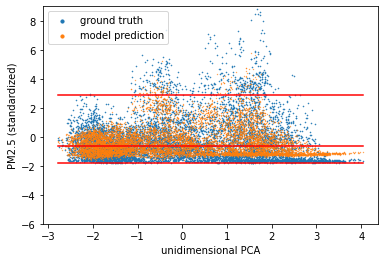

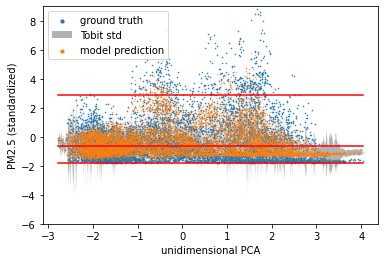

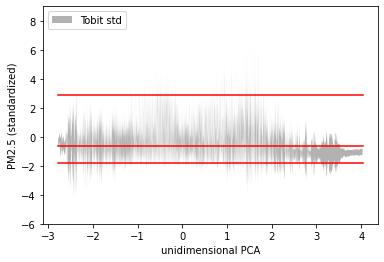

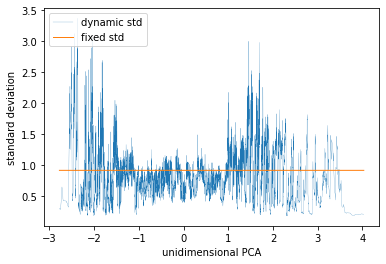

Absolute error - validation 0.4533870816230774
R2 - validation 0.3942763925573126
Absolute error - test 0.7501134872436523
R2 - test 0.44788781744662176


In [ ]:
# plot_and_evaluate_CEnsored(CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED, model_fn = get_model, isGrid = False)
plot_and_evaluate_CEnsored(CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED, model_fn = get_model, isGrid = True)